# Direct coupling of two transmon qubit

### Setting up the environment

In [1]:
import os
import sys

# Get the current file path
current_dir = os.getcwd()
# Get the parent folder path
parent_dir = os.path.dirname(current_dir)

# Add the parent folder path to sys.path
sys.path.append(parent_dir)

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import constants
import scipy.sparse.linalg
import scipy.sparse as sparse
import json

from tqdm import tqdm

from lib.transmon import transmon

from lib.direct_coupling_circuit import circuit

# Setting up constants
h = constants.h
hbar = constants.hbar
pi = np.pi

## Basics

In [3]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 3.1e-15

# First transmon cosntant
Ej_1 = 153e9
Ct1 = 12e-15
flux_1 = 0.5
ncut_1 = 10

# Second transmon constant
Ej_2 = 21.3e9
Ct2 = 18e-13
flux_2 = 0.5
ncut_2 = 10

# Creation of transmon
transmon_1 = transmon(Ej_1, Ct1, ng, flux_1, ncut_1)
transmon_2 = transmon(Ej_2, Ct2, ng, flux_2, ncut_2)

# Creation of circuit
system = circuit(Cc, ng, [transmon_1, transmon_2])

### Visualizing the Hamiltonians

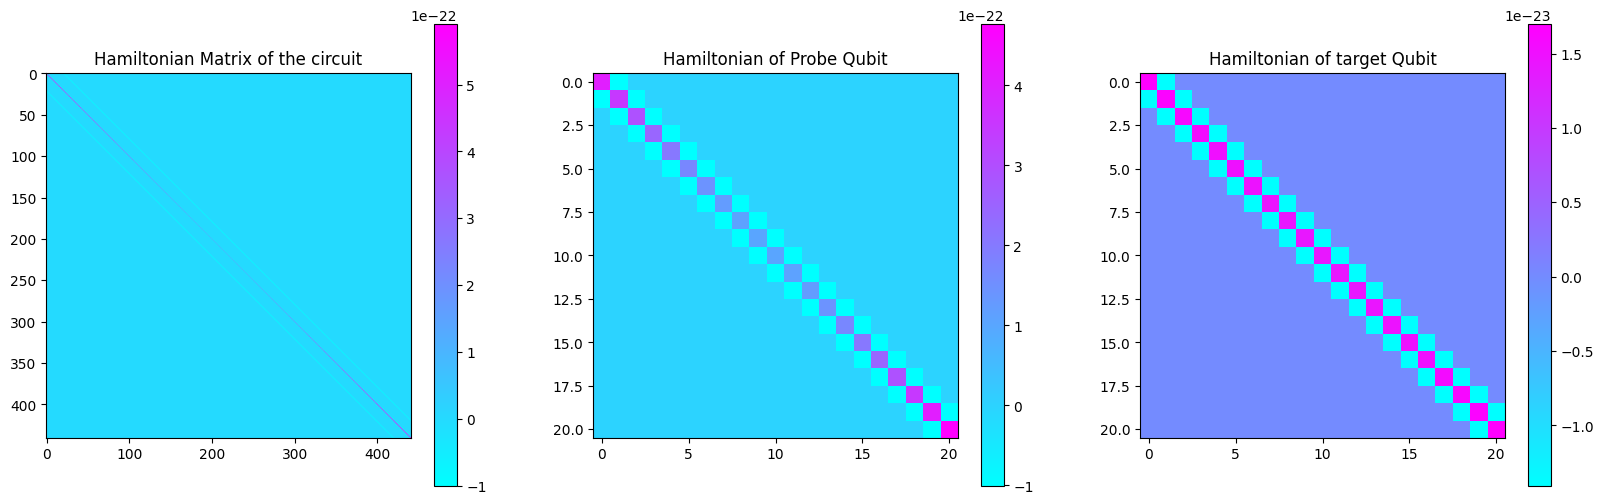

In [10]:
# Exctracting the Hamiltonian
H_circ = system.H()
H_t1 = system.H_t1()
H_t2 = system.H_t2()
type(H_circ)


type(H_circ)
if type(H_circ) == scipy.sparse.csr_matrix:
    H_circ = H_circ.toarray()
    H_t1 = H_t1.toarray()
    H_t2 = H_t2.toarray()

f = plt.figure(figsize=(20,6))

# Plotting the Hamiltonian
ax1 = f.add_subplot(131)
ax1.title.set_text('Hamiltonian Matrix of the circuit')
im1 = ax1.imshow(np.real(H_circ), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(132)
ax2.title.set_text('Hamiltonian of Probe Qubit')
im2 = ax2.imshow(np.real(H_t1), cmap=plt.get_cmap('cool'))
f.colorbar(im2)


ax3 = f.add_subplot(133)
ax3.title.set_text('Hamiltonian of target Qubit')
im3 = ax3.imshow(np.real(H_t2), cmap=plt.get_cmap('cool'))
f.colorbar(im3)

plt.show()

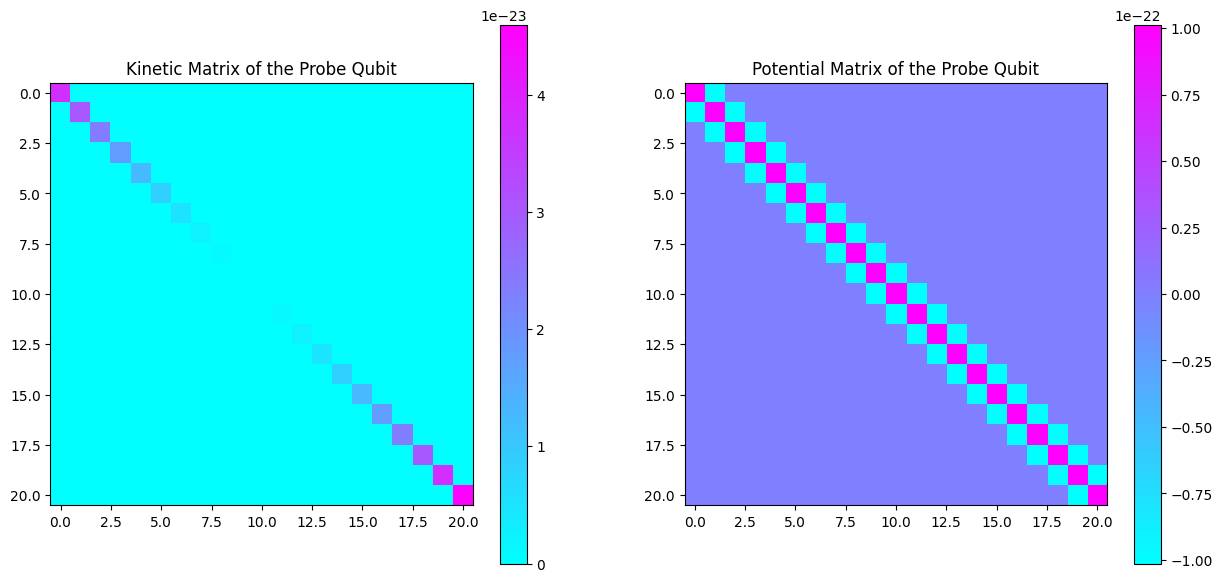

In [5]:
kin_probe = system.get_kinetic_t1()
pot_probe = system.get_potential_t1()

if type(kin_probe) == scipy.sparse.csr_matrix:
    kin_probe = kin_probe.toarray()
    pot_probe = pot_probe.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Probe Qubit')
im1 = ax1.imshow(np.real(kin_probe), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Probe Qubit')
im2 = ax2.imshow(np.real(pot_probe), cmap=plt.get_cmap('cool'))
f.colorbar(im2)
plt.show()

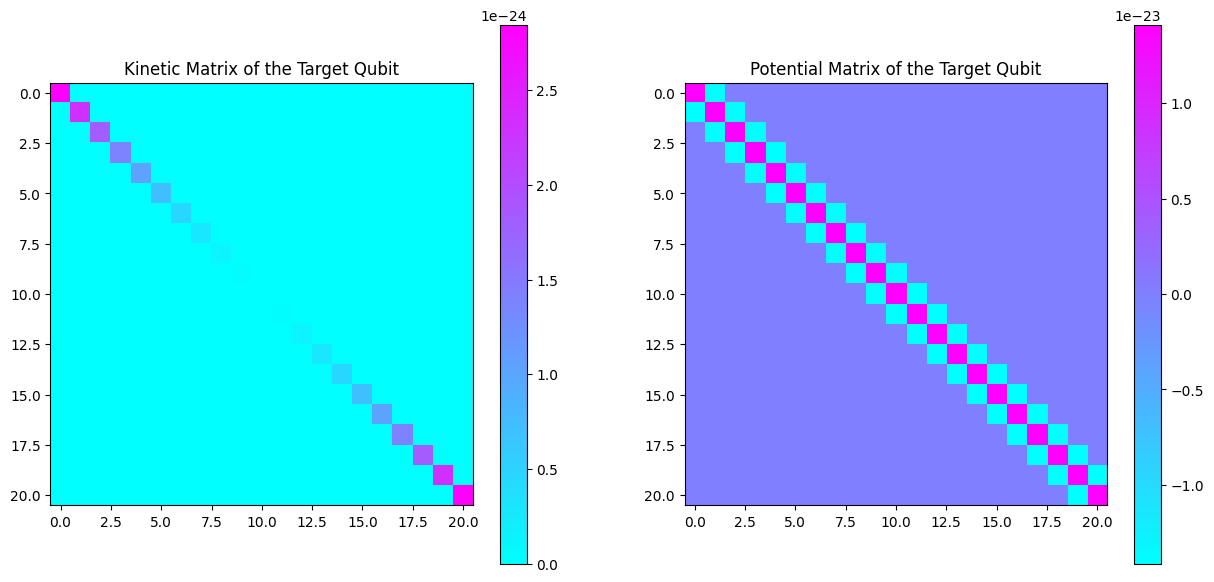

In [6]:
kin_target = system.get_kinetic_t2()
pot_target = system.get_potential_t2()

if type(kin_target) == scipy.sparse.csr_matrix:
    kin_target = kin_target.toarray()
    pot_target = pot_target.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Target Qubit')
im1 = ax1.imshow(np.real(kin_target), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Target Qubit')
im2 = ax2.imshow(np.real(pot_target), cmap=plt.get_cmap('cool'))
f.colorbar(im2)
plt.show()

## Determine Hamiltonian parameter

We assume that the Hamiltonian can be approximated by

\begin{equation}
    \mathcal{H} = \frac{\Delta_p}{2} \sigma^{(p)}_z + \frac{\Delta_t}{2} \sigma^{(t)}_z + i g_\parallel \sigma^{(p)}_z  n^{(t)} + i g_\perp \sigma^{(p)}_x n^{(t)}
\end{equation}

In [2]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 3.1e-15

# First transmon cosntant
Ej_1 = 100e9
Ct1 = 100e-15
flux_1 = 0.5
ncut_1 = 6

# Second transmon constant
Ej_2 = 100e9
Ct2 = 100e-15
flux_2 = 0.5
ncut_2 = 6

# Creation of transmon
transmon_1 = transmon(Ej_1, Ct1, ng, flux_1, ncut_1)
transmon_2 = transmon(Ej_2, Ct2, ng, flux_2, ncut_2)

# Creation of circuit
system1 = circuit(Cc, ng, [transmon_1, transmon_2])

In [6]:
delta_p = system1.calc_delta_probe()
delta_t = system1.calc_delta_target()
g_parr = system1.calc_g_parr()
g_perp = system1.calc_g_perp()

system1.print_params()
print(f'∆_p: {np.real(delta_p) * 1e-9 / h} GHz')
print(f'∆_t: {np.real(delta_t) * 1e-9 / h} GHz')
print(f'g_parr: {np.real(g_parr)}')
print(f'g_perp: {np.real(g_perp)}')

Ejp:    100.0 GHz
Ejt:    100.0 GHz
Cjp:    100.0 fF
Cjt:    100.0 fF
Cc:    3.1 fF
ng:    0.5
Ejp/Ecp1: 532.260089810859
Ejt/Ect2: 532.260089810859
∆_p: 20.468433598935718 GHz
∆_t: 20.30245281256248 GHz
g_parr: -2.938735877055719e-39
g_perp: 1.9515042933573132e-39


## Analyse

### Varying Cc and ng

#### Varying ng for Delta p

In [7]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 3e-15

# First transmon cosntant
Ej_1 = 100e9
Ct1 = 100e-15
flux_1 = 0.5
ncut_1 = 10

# Second transmon constant
Ej_2 = 100e9
Ct2 = 100e-15
flux_2 = 0.5
ncut_2 = 10

# Creation of transmon
transmon_1 = transmon(Ej_1, Ct1, ng, flux_1, ncut_1)
transmon_2 = transmon(Ej_2, Ct2, ng, flux_2, ncut_2)

# Creation of circuit
system2 = circuit(Cc, ng, [transmon_1, transmon_2])

  0%|          | 0/700 [00:00<?, ?it/s]

100%|██████████| 700/700 [00:09<00:00, 72.32it/s]


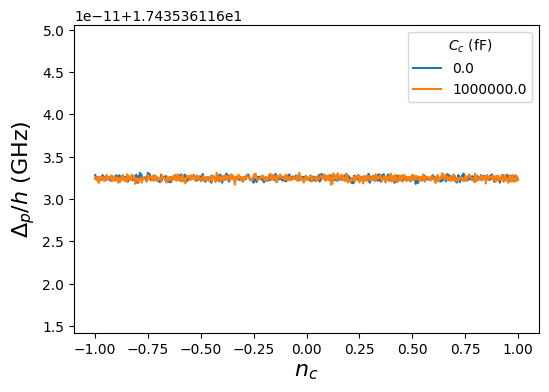

In [8]:
fig17b_ngs = np.linspace(-1, 1, 700)
Ccs = np.linspace(0, 10e-10, 2)
# Ccs = np.linspace(0, 10e-15, 11)
fig17b_data_p, fig17b_data_t = {}, {}

for Cc in Ccs:
    system2.Cc = Cc
    fig17b_data_p[Cc], fig17b_data_t[Cc] = [], []
    for ng in tqdm(fig17b_ngs):
        system2.ng = ng

        # Full Hamiltonina Approach
        delta_p = system2.calc_delta_probe(update=True)
        delta_t = system2.calc_delta_target()
        evals_t, evecs_t = system2.diagonalise_t1()
        delta_p = evals_t[1] - evals_t[0]
        fig17b_data_p[Cc].append(delta_p)
        fig17b_data_t[Cc].append(delta_t)

pparam = dict(xlabel='$n_c$', ylabel='$\\Delta_p / h$ (GHz)')


fig, ax = plt.subplots(figsize=(6,4))
for Cc in fig17b_data_p.keys():
    ax.plot(fig17b_ngs, [np.abs(np.real(delta * 1e-9)) / h for delta in fig17b_data_p[Cc]], label=round(Cc * 1e15, 1))
ax.legend(title='$C_c$ (fF)')
ax.set(**pparam)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)

plt.show()

#### Varying ng

In [9]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 3e-15

# First transmon cosntant
Ej_1 = 100e9
Ct1 = 100e-15
flux_1 = 0.5
ncut_1 = 10

# Second transmon constant
Ej_2 = 100e9
Ct2 = 100e-15
flux_2 = 0.5
ncut_2 = 10

# Creation of transmon
transmon_1 = transmon(Ej_1, Ct1, ng, flux_1, ncut_1)
transmon_2 = transmon(Ej_2, Ct2, ng, flux_2, ncut_2)

# Creation of circuit
system3 = circuit(Cc, ng, [transmon_1, transmon_2])

print(f'Ejp/Ecp1: {np.real(system3.t1.Ej/(constants.e**2/(2*(system3.t1.C+system3.Cc))))}')
print(f'Ejp/Ecp2: {np.real(system3.t2.Ej/(constants.e**2/(2*(system3.t2.C+system3.Cc))))}')

Ejp/Ecp1: 531.743833661673
Ejp/Ecp2: 531.743833661673


100%|██████████| 100/100 [00:01<00:00, 75.65it/s]


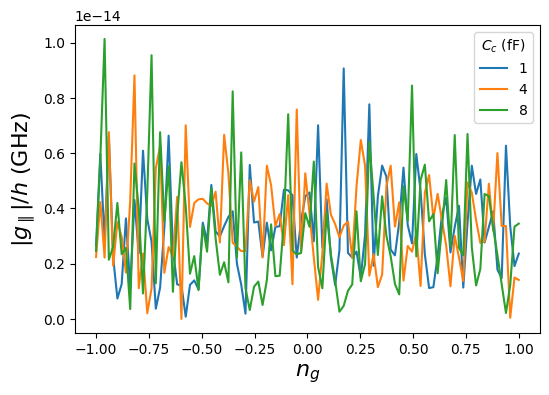

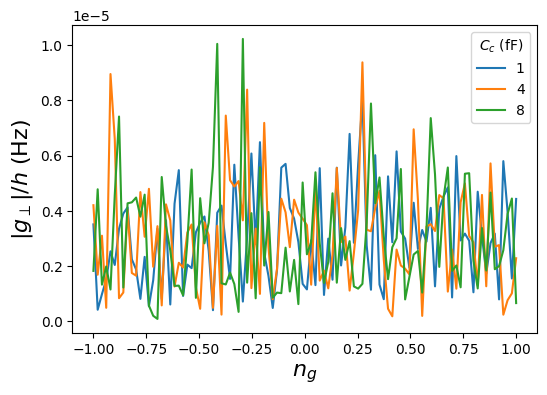

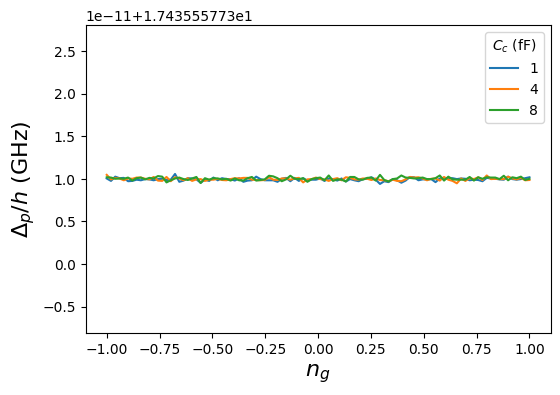

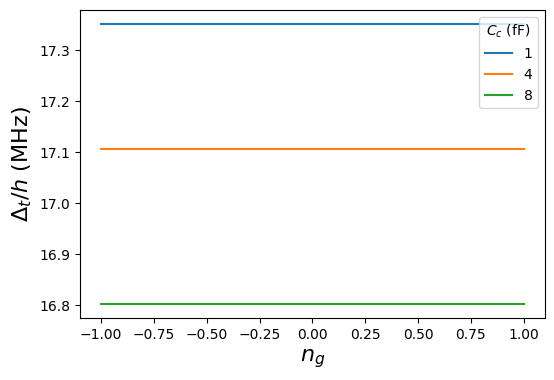

In [10]:
fig17c_ngs = np.linspace(-1, 1, 100)
fig_17c_Ccs = [val * 1e-15 for val in range(1, 9)]
fig_17c_Ccs = [fig_17c_Ccs[0], fig_17c_Ccs[3], fig_17c_Ccs[-1]]
fig17c_data = {}


for Cc in fig_17c_Ccs:
    system3.Cc = Cc
    fig17c_data[Cc] = {
        'g_parr': [],
        'g_perp': [],
        'delta_p': [],
        'delta_t': []
    }
    for ng in tqdm(fig17c_ngs):
        system3.ng = ng

        # Full Hamiltonina Approach
        g_parr = system3.calc_g_parr(update=True)
        fig17c_data[Cc]['g_parr'].append(g_parr)

        # Full Hamiltonina Approach
        g_perp = system3.calc_g_perp()
        fig17c_data[Cc]['g_perp'].append(g_perp)

        # Full Hamiltonina Approach
        delta_p = system3.calc_delta_probe()
        fig17c_data[Cc]['delta_p'].append(delta_p)

        # Full Hamiltonina Approach
        delta_t = system3.calc_delta_target()
        fig17c_data[Cc]['delta_t'].append(delta_t)


pparam = dict(xlabel='$n_g$', ylabel='$| g_\parallel | / h$ (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    for Cc in fig17c_data.keys():
        ax.plot(fig17c_ngs, [np.abs(g_parr * 1e-9) / h for g_parr in fig17c_data[Cc]['g_parr']], label=round(Cc * 1e15))
    ax.legend(title='$C_c$ (fF)')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()

pparam = dict(xlabel='$n_g$', ylabel='$| g_\perp | / h$ (Hz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    for Cc in fig17c_data.keys():
        ax.plot(fig17c_ngs, [np.abs(g_perp) / h for g_perp in fig17c_data[Cc]['g_perp']], label=round(Cc * 1e15))
    ax.legend(title='$C_c$ (fF)')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()

pparam = dict(xlabel='$n_g$', ylabel='$\\Delta_p / h$ (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    for Cc in fig17c_data.keys():
        ax.plot(fig17c_ngs, [np.abs(g_perp) * 1e-9 / h for g_perp in fig17c_data[Cc]['delta_p']], label=round(Cc * 1e15))
    ax.legend(title='$C_c$ (fF)')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()

pparam = dict(xlabel='$n_g$', ylabel='$\\Delta_t / h$ (MHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    for Cc in fig17c_data.keys():
        ax.plot(fig17c_ngs, [np.abs(g_perp) * 1e-9 / h for g_perp in fig17c_data[Cc]['delta_t']], label=round(Cc * 1e15))
    ax.legend(title='$C_c$ (fF)')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()


#### Varying Cc for g parr

In [21]:
# Initialize transmon

# Circuit constant
ng = 0.5
Cc = 3e-15

# First transmon cosntant
Ej_1 = 10e9
Ct1 = 100e-15
flux_1 = 0.5
ncut_1 = 10

# Second transmon constant
Ej_2 = 10e9
Ct2 = 100e-15
flux_2 = 0.5
ncut_2 = 10

# Creation of transmon
transmon_1 = transmon(Ej_1, Ct1, ng, flux_1, ncut_1)
transmon_2 = transmon(Ej_2, Ct2, ng, flux_2, ncut_2)

# Creation of circuit
system8 = circuit(Cc, ng, [transmon_1, transmon_2])
system8.print_params()

Ejp:    9.999999999999998 GHz
Ejt:    9.999999999999998 GHz
Cjp:    100.0 fF
Cjt:    100.0 fF
Cc:    3.0 fF
ng:    0.5
Ejp/Ecp1: 53.17438336616729
Ejt/Ect2: 53.17438336616729


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Baptiste\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 100/100 [00:01<00:00, 77.13it/s]


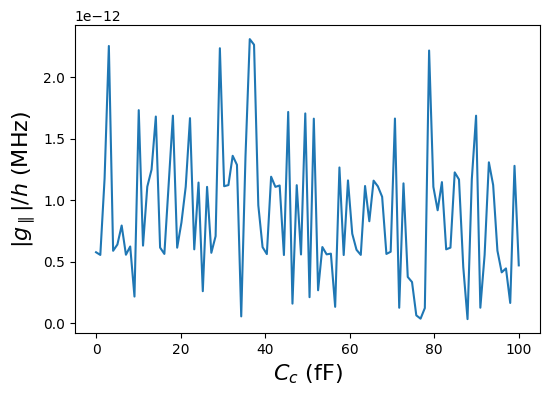

In [22]:
fig_17d_Ccs = np.linspace(0, 10e-14, 100)

fig17d_data = []

for Cc in tqdm(fig_17d_Ccs):
    system8.Cc = Cc

    # Full Hamiltonina Approach
    g_parr = system8.calc_g_parr(update=True)
    fig17d_data.append(g_parr)

pparam = dict(xlabel='$C_c$ (fF)', ylabel='$| g_\parallel | / h$ (MHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_17d_Ccs], [np.abs(g_parr) * 1e-6 / h for g_parr in fig17d_data])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    plt.show()

### Adjusting Probe-Target Detunning

#### Probe Qubit Tuning

##### Varying Ejp

In [13]:
# Initialize transmon

# Circuit constant
ng = 0.3235
Cc = 3e-15

# First transmon cosntant
Ej_1 = 100e9
Ct1 = 100e-15
flux_1 = 0.5
ncut_1 = 10

# Second transmon constant
Ej_2 = 100e9
Ct2 = 100e-15
flux_2 = 0.5
ncut_2 = 10

# Creation of transmon
transmon_1 = transmon(Ej_1, Ct1, ng, flux_1, ncut_1)
transmon_2 = transmon(Ej_2, Ct2, ng, flux_2, ncut_2)

# Creation of circuit
system4 = circuit(Cc, ng, [transmon_1, transmon_2])

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Baptiste\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 100/100 [00:01<00:00, 74.66it/s]


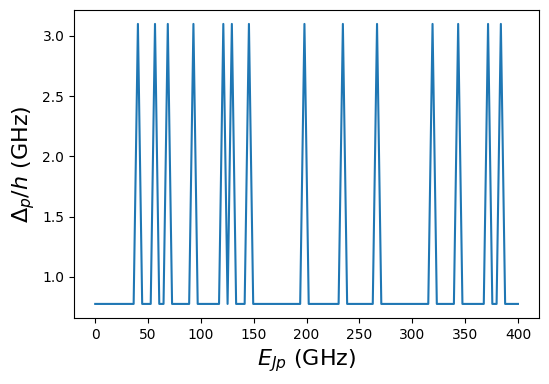

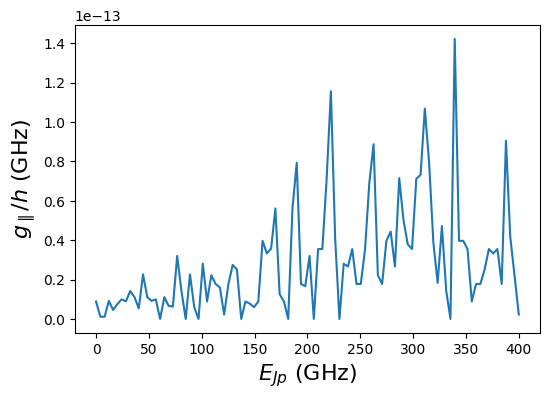

In [14]:
fig_pt_detuning_Ejp = np.linspace(0, 400e9, 100)
fig_pt_detuning_Ejp_delta_p = []
fig_pt_detuning_Ejp_g_parr = []

for Ejp in tqdm(fig_pt_detuning_Ejp):
    system4.t1.Ej = Ejp * h
    
    delta_p = system4.calc_delta_probe(update=True)
    fig_pt_detuning_Ejp_delta_p.append(delta_p)
    
    g_parr = system4.calc_g_parr()
    fig_pt_detuning_Ejp_g_parr.append(g_parr)

pparam = dict(xlabel='$E_{Jp}$ (GHz)', ylabel='$\\Delta_p / h$ (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e-9 for val in fig_pt_detuning_Ejp], [np.abs(delta_p) * 1e-9 / h for delta_p in fig_pt_detuning_Ejp_delta_p])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()

pparam = dict(xlabel='$E_{Jp}$ (GHz)', ylabel='$g_\\parallel / h$ (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e-9 for val in fig_pt_detuning_Ejp], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ejp_g_parr])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()

##### Varying Cjp

In [15]:
# Initialize transmon

# Circuit constant
ng = 0.3235
Cc = 3e-15

# First transmon cosntant
Ej_1 = 100e9
Ct1 = 100e-15
flux_1 = 0.5
ncut_1 = 10

# Second transmon constant
Ej_2 = 100e9
Ct2 = 100e-15
flux_2 = 0.5
ncut_2 = 10

# Creation of transmon
transmon_1 = transmon(Ej_1, Ct1, ng, flux_1, ncut_1)
transmon_2 = transmon(Ej_2, Ct2, ng, flux_2, ncut_2)

# Creation of circuit
system5 = circuit(Cc, ng, [transmon_1, transmon_2])

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Baptiste\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 100/100 [00:01<00:00, 73.12it/s]


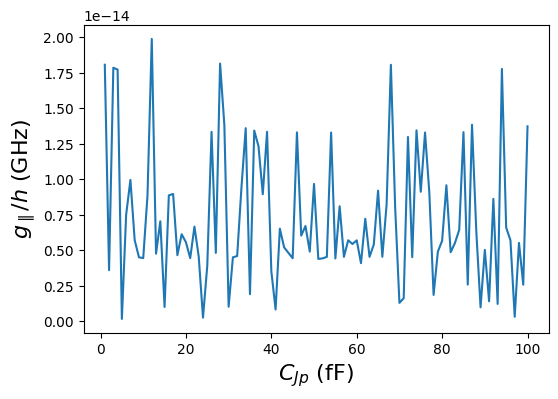

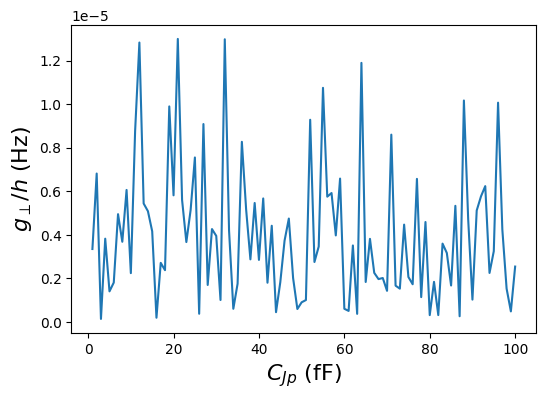

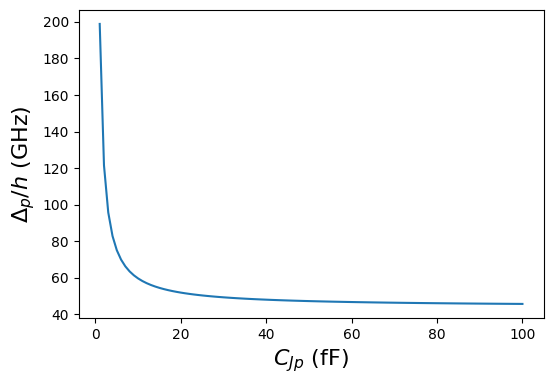

In [16]:
fig_pt_detuning_Cjp = np.linspace(1e-15, 1e-13, 100)
fig_pt_detuning_Cjp_g_parr = []
fig_pt_detuning_Cjp_g_perp = []
fig_pt_detuning_Cjp_delta_p = []

for Cjp in tqdm(fig_pt_detuning_Cjp):
    system5.t1.C = Cjp

    g_parr = system5.calc_g_parr(update=True)
    fig_pt_detuning_Cjp_g_parr.append(g_parr)
    
    g_perp = system5.calc_g_perp()
    fig_pt_detuning_Cjp_g_perp.append(g_perp)
    
    delta_p = system5.calc_delta_probe()
    fig_pt_detuning_Cjp_delta_p.append(delta_p)

pparam = dict(xlabel='$C_{Jp}$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_pt_detuning_Cjp], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Cjp_g_parr])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()
    
pparam = dict(xlabel='$C_{Jp}$ (fF)', ylabel='$g_\\perp / h$ (Hz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_pt_detuning_Cjp], [np.abs(g_perp) / h for g_perp in fig_pt_detuning_Cjp_g_perp])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()

pparam = dict(xlabel='$C_{Jp}$ (fF)', ylabel='$\\Delta_p / h$ (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_pt_detuning_Cjp], [np.abs(delta_p) * 1e-9 / h for delta_p in fig_pt_detuning_Cjp_delta_p])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()

#### Target Qubit Tuning

##### Varying Ejt

In [17]:
# Initialize transmon

# Circuit constant
ng = 0.3235
Cc = 6.76e-15

# First transmon cosntant
Ej_1 = 2.86*4e+11
Ct1 = 4.767e-15
flux_1 = 0.5
ncut_1 = 10

# Second transmon constant
Ej_2 = 4.851e+10
Ct2 = 1.683e-13 + 1.683e-13
flux_2 = 0.5
ncut_2 = 10

# Creation of transmon
transmon_1 = transmon(Ej_1, Ct1, ng, flux_1, ncut_1)
transmon_2 = transmon(Ej_2, Ct2, ng, flux_2, ncut_2)

# Creation of circuit
system6 = circuit(Cc, ng, [transmon_1, transmon_2])
system6.print_params()

Ejp:    1144.0 GHz
Ejt:    48.510000000000005 GHz
Cjp:    4.767 fF
Cjt:    336.6 fF
Cc:    6.76 fF
ng:    0.3235
Ejp/Ecp1: 680.7812018628263
Ejt/Ect2: 859.8965619263838


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Baptiste\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 100/100 [00:01<00:00, 64.96it/s]


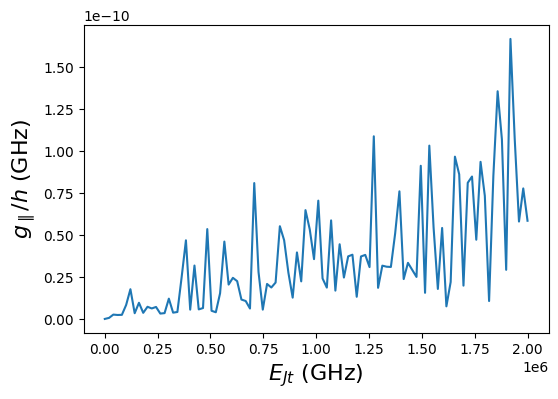

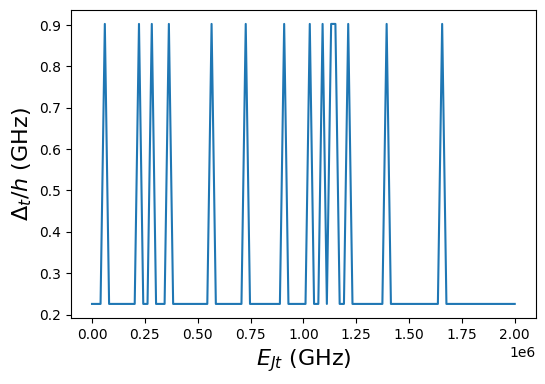

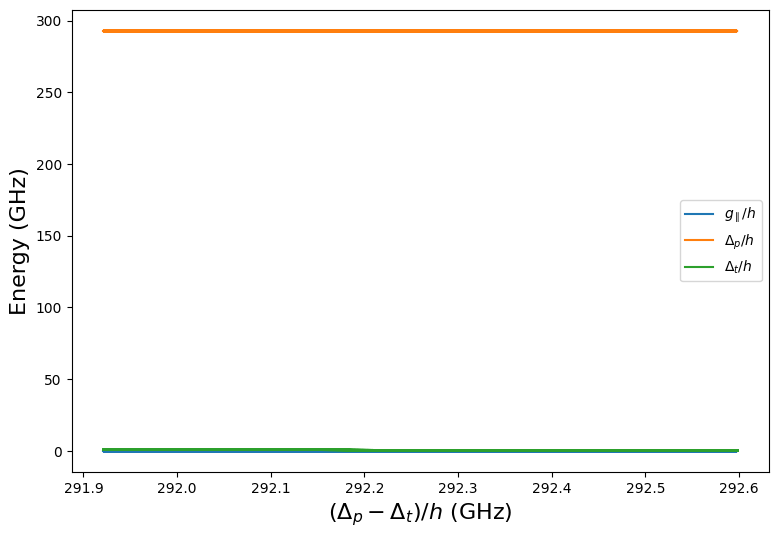

In [18]:
# fig_pt_detuning_Ejt = np.linspace(8.5e9, 27e9, 20)
fig_pt_detuning_Ejt = np.linspace(0, 200e13, 100)
fig_pt_detuning_Ejt_g_parr = []
fig_pt_detuning_Ejt_delta_t = []
fig_pt_detuning_Ejt_delta_t_bare = []
fig_pt_detuning_Ejt_delta_p = []



for Ejt in tqdm(fig_pt_detuning_Ejt):
    system6.t2.Ej = Ejt * h

    # Full Hamiltonina Approach
    g_parr = system6.calc_g_parr(update=True)
    fig_pt_detuning_Ejt_g_parr.append(g_parr)
    
    delta_t = system6.calc_delta_target()
    fig_pt_detuning_Ejt_delta_t.append(delta_t)
    
    evals_t, evecs_t = system6.diagonalise_t2()
    fig_pt_detuning_Ejt_delta_t_bare.append(evals_t[1] - evals_t[0])
    
    delta_p = system6.calc_delta_probe()
    fig_pt_detuning_Ejt_delta_p.append(delta_p)

pparam = dict(xlabel='$E_{Jt}$ (GHz)', ylabel='$g_\\parallel / h$ (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e-9 for val in fig_pt_detuning_Ejt], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ejt_g_parr])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()

pparam = dict(xlabel='$E_{Jt}$ (GHz)', ylabel='$\\Delta_t / h$ (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e-9 for val in fig_pt_detuning_Ejt], [np.abs(delta_t) * 1e-9 / h for delta_t in fig_pt_detuning_Ejt_delta_t])
    #ax.plot([val * 1e-9 for val in fig_pt_detuning_Ejt], [np.abs(delta_t) * 1e-9 / h for delta_t in fig_pt_detuning_Ejt_delta_t_bare])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()

pparam = dict(xlabel='$(\\Delta_p - \\Delta_t) / h$ (GHz)', ylabel='Energy (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot([(np.abs(fig_pt_detuning_Ejt_delta_p[idx]) - np.abs(fig_pt_detuning_Ejt_delta_t[idx])) * 1e-9 / h for idx in range(len(fig_pt_detuning_Ejt))], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ejt_g_parr], label='$g_\parallel / h$')
    ax.plot([(np.abs(fig_pt_detuning_Ejt_delta_p[idx]) - np.abs(fig_pt_detuning_Ejt_delta_t[idx])) * 1e-9 / h for idx in range(len(fig_pt_detuning_Ejt))], [np.abs(delta_p) * 1e-9 / h for delta_p in fig_pt_detuning_Ejt_delta_p], label='$\Delta_p / h$')
    ax.plot([(np.abs(fig_pt_detuning_Ejt_delta_p[idx]) - np.abs(fig_pt_detuning_Ejt_delta_t[idx])) * 1e-9 / h for idx in range(len(fig_pt_detuning_Ejt))], [np.abs(delta_t) * 1e-9 / h for delta_t in fig_pt_detuning_Ejt_delta_t], label='$\Delta_t / h$')
    ax.set(**pparam)
    plt.legend()
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

    plt.show()   

##### Varying Ct

In [19]:
# Initialize transmon

# Circuit constant
ng = 0.3235
Cc = 6.76e-15

# First transmon cosntant
Ej_1 = 2.86*4e+11
Ct1 = 4.767e-16
flux_1 = 0.5
ncut_1 = 10

# Second transmon constant
Ej_2 = 4.851e+10
Ct2 = 1.683e-14 + 1.683e-14 
flux_2 = 0.5
ncut_2 = 10

# Creation of transmon
transmon_1 = transmon(Ej_1, Ct1, ng, flux_1, ncut_1)
transmon_2 = transmon(Ej_2, Ct2, ng, flux_2, ncut_2)

# Creation of circuit
system7 = circuit(Cc, ng, [transmon_1, transmon_2])

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\Baptiste\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 100/100 [00:01<00:00, 72.34it/s]


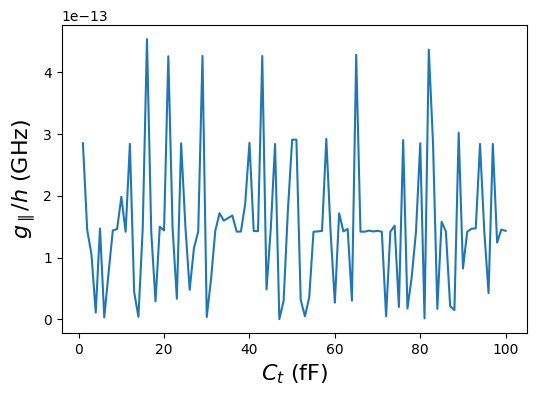

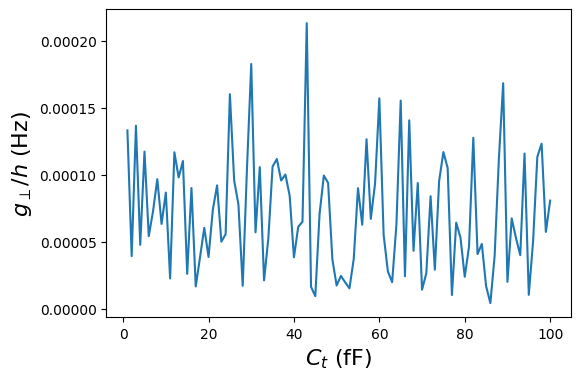

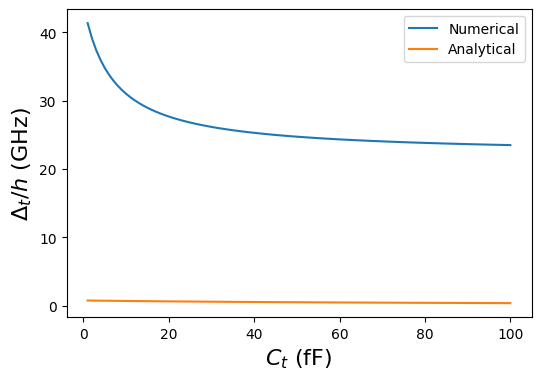

In [20]:
fig_pt_detuning_Ct = np.linspace(1e-15, 1e-13, 100)
fig_pt_detuning_Ct_g_parr = []
fig_pt_detuning_Ct_g_perp = []
fig_pt_detuning_Ct_delta_t = []

for Ct in tqdm(fig_pt_detuning_Ct):
    system7.t2.C = Ct

    g_parr = system7.calc_g_parr(update=True)
    fig_pt_detuning_Ct_g_parr.append(g_parr)
    
    g_perp = system7.calc_g_perp()
    fig_pt_detuning_Ct_g_perp.append(g_perp)
    
    delta_t = system7.calc_delta_target()
    fig_pt_detuning_Ct_delta_t.append(delta_t)

def safe_div(num, denom):
    if denom == 0:
        return 0
    else:
        return num / denom

fig_pt_detuning_Ct_delta_t_theory = []
for Ct in fig_pt_detuning_Ct:
    Ect = safe_div(constants.e**2, 2 * (system7.t2.C + Ct))
    omega = np.sqrt((system7.t2.Ej * h)**2 + (4 * Ect)**2)
    fig_pt_detuning_Ct_delta_t_theory.append(omega)


pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_\\parallel / h$ (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(g_parr) * 1e-9 / h for g_parr in fig_pt_detuning_Ct_g_parr])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    plt.show()
    
pparam = dict(xlabel='$C_t$ (fF)', ylabel='$g_\\perp / h$ (Hz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(g_perp) / h for g_perp in fig_pt_detuning_Ct_g_perp])
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    plt.show()

pparam = dict(xlabel='$C_t$ (fF)', ylabel='$\\Delta_t / h$ (GHz)')

with plt.style.context([]):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(delta_t) * 1e-9 / h for delta_t in fig_pt_detuning_Ct_delta_t], label='Numerical')
    ax.plot([val * 1e15 for val in fig_pt_detuning_Ct], [np.abs(delta_t_bare) * 1e-9 / h for delta_t_bare in fig_pt_detuning_Ct_delta_t_theory], label='Analytical')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    plt.legend()
    plt.show()